Initial Part Constant For All Models

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf
from tensorflow import keras

np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
#mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Specify the path to your CSV file
csv_file_path = '/content/drive/MyDrive/IS_STLF_Dataset_2012_2015/ERCOT_2012_to_2015.csv'

Model 2: Finding best hyperparameters/ architecture

In [ ]:
# Load the dataset into a DataFrame
df = pd.read_csv(csv_file_path)

# Display the first few rows of the DataFrame
df.head(5)

,Date,Day of Week(0-6),Day of the Month(1-31),Month of the Year(1-12),Time of Day(0-23),Holidays,Humidity,Temperature,Load WEST
0,1/1/2012,6,1,1,1,1,34.89,13.2,849.000892
1,1/1/2012,6,1,1,2,1,37.89,12.0,845.097364
2,1/1/2012,6,1,1,3,1,46.46,10.2,840.902849
3,1/1/2012,6,1,1,4,1,54.48,8.4,845.452257
4,1/1/2012,6,1,1,5,1,63.22,6.6,862.369386


In [ ]:
# Extract features and target variable
features = ['Day of Week(0-6)', 'Day of the Month(1-31)', 'Month of the Year(1-12)', 'Time of Day(0-23)', 'Holidays', 'Humidity', 'Temperature']
target_variable = 'Load WEST'
data = df[['Day of Week(0-6)', 'Day of the Month(1-31)', 'Month of the Year(1-12)', 'Time of Day(0-23)', 'Holidays', 'Humidity', 'Temperature', 'Load WEST']]

In [ ]:
# Normalize data using Min-Max normalization
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data)

In [ ]:
type(data_normalized)

numpy.ndarray

In [ ]:
data_normalized.shape

(35064, 8)

In [ ]:
#2015 starts fromrow 26304
#checking
data.iloc[26303]

Day of Week(0-6)              3.00000
Day of the Month(1-31)        1.00000
Month of the Year(1-12)       1.00000
Time of Day(0-23)             0.00000
Holidays                      1.00000
Humidity                     77.15000
Temperature                   1.20000
Load WEST                  1504.43762
Name: 26303, dtype: float64

In [ ]:
data_normalized[26303]

array([0.5       , 0.        , 0.        , 0.        , 1.        ,
       0.75412989, 0.20517928, 0.69694446])

In [ ]:
train_set=data_normalized[:26303]
test_set=data_normalized[26303:]

In [ ]:
print(train_set.shape)
print(test_set.shape)

(26303, 8)
(8761, 8)


In [ ]:
# Function to prepare sequences for LSTM
def prepare_sequences(data, look_back):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), :])
        y.append(data[i + look_back, -1])  # Assuming Load WEST is the last column
    return np.array(X), np.array(y)

# Set the look-back window
look_back = 12 # Adjust this value based on your analysis

In [ ]:
# Prepare sequences for train set
X_train_I, y_train_I = prepare_sequences(train_set, look_back)

In [ ]:
# Prepare sequences for test set
X_test, y_test = prepare_sequences(test_set, look_back)

In [ ]:
print(X_train_I.shape)
print(y_train_I.shape)
print(X_test.shape)
print(y_test.shape)

(26291, 12, 8)
(26291,)
(8749, 12, 8)
(8749,)


In [ ]:
# Split the data into training, validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_I, y_train_I, test_size=0.2, random_state=42)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(21032, 12, 8)
(21032,)
(5259, 12, 8)
(5259,)


In [ ]:
X_train.shape[1]

12

In [ ]:
pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 2.7 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU
from tensorflow.keras.callbacks import EarlyStopping
from kerastuner.tuners import RandomSearch
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Assuming you have X_train, y_train, X_val, y_val defined

# Function to build the model
def build_model(hp):
    model = Sequential()

    # Tune the number of LSTM units
    model.add(GRU(units=hp.Int('units', min_value=30, max_value=80, step=10),
                   return_sequences=True,
                   input_shape=(X_train.shape[1], X_train.shape[2])))

    # Tune the number of intermediate LSTM layers
    for _ in range(hp.Int('num_layers', min_value=1, max_value=5)):
        model.add(GRU(units=hp.Int('units', min_value=30, max_value=80, step=10), return_sequences=True))

    # Manually set return_sequences=False for the last LSTM layer
    model.add(GRU(units=hp.Int('units_last', min_value=30, max_value=80, step=10), return_sequences=False))

    # Dense layer for final prediction
    model.add(Dense(units=1))

    # Choose between Adam and Nadam optimizers
    optimizer_choice = hp.Choice('optimizer', ['adam', 'nadam'])

    # Compile the model
    model.compile(optimizer=optimizer_choice, loss='mean_squared_error')

    return model

# Define the tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,  # Adjust as needed
    executions_per_trial=1,
    directory='my_tuner_directory',
    project_name='lstm_tuning'
)

# Early stopping to stop training when the validation loss doesn't improve
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Perform the search
tuner.search(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the final model with the best hyperparameters
final_model = build_model(best_hps)


Trial 10 Complete [00h 17m 15s]
val_loss: 0.0001335972046945244

Best val_loss So Far: 0.00010635465878294781
Total elapsed time: 02h 17m 53s


In [ ]:
best_hps

In [ ]:
# Print the best hyperparameters
print("Best Hyperparameters:")
print(f"Number of Units: {best_hps.get('units')}")
print(f"Number of Intermediate Layers: {best_hps.get('num_layers')}")
print(f"Number of Units in Last Layer: {best_hps.get('units_last')}")

Best Hyperparameters:
Number of Units: 50
Number of Intermediate Layers: 4
Number of Units in Last Layer: 30


In [ ]:
type(best_hps)

keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters

In [ ]:
# Assume you have obtained best_hps as mentioned before

# Print all attributes and their values
for key, value in best_hps.__dict__.items():
    print(f"{key}: {value}")


_name_scopes: []
_conditions: []
_hps: defaultdict(<class 'list'>, {'units': [Int(name: 'units', min_value: 30, max_value: 80, step: 10, sampling: linear, default: 30)], 'num_layers': [Int(name: 'num_layers', min_value: 1, max_value: 5, step: 1, sampling: linear, default: 1)], 'units_last': [Int(name: 'units_last', min_value: 30, max_value: 80, step: 10, sampling: linear, default: 30)], 'optimizer': [Choice(name: 'optimizer', values: ['adam', 'nadam'], ordered: False, default: adam)]})
_space: [Int(name: 'units', min_value: 30, max_value: 80, step: 10, sampling: linear, default: 30), Int(name: 'num_layers', min_value: 1, max_value: 5, step: 1, sampling: linear, default: 1), Int(name: 'units_last', min_value: 30, max_value: 80, step: 10, sampling: linear, default: 30), Choice(name: 'optimizer', values: ['adam', 'nadam'], ordered: False, default: adam)]
values: {'units': 50, 'num_layers': 4, 'units_last': 30, 'optimizer': 'adam'}
active_scopes: []
inactive_scopes: []


In [ ]:
# Train the final model
history = final_model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Evaluate on the test set
test_loss = final_model.evaluate(X_test, y_test)

# You can access the best model using the 'best_model' variable

Epoch 1/100
658/658 [==============================] - 51s 56ms/step - loss: 0.0046 - val_loss: 4.7183e-04
Epoch 2/100
658/658 [==============================] - 36s 54ms/step - loss: 4.1888e-04 - val_loss: 3.1827e-04
Epoch 3/100
658/658 [==============================] - 35s 53ms/step - loss: 3.9140e-04 - val_loss: 5.0565e-04
Epoch 4/100
658/658 [==============================] - 35s 53ms/step - loss: 3.8435e-04 - val_loss: 2.7627e-04
Epoch 5/100
658/658 [==============================] - 34s 52ms/step - loss: 3.4554e-04 - val_loss: 3.0566e-04
Epoch 6/100
658/658 [==============================] - 34s 52ms/step - loss: 2.9979e-04 - val_loss: 3.7224e-04
Epoch 7/100
658/658 [==============================] - 34s 52ms/step - loss: 2.8926e-04 - val_loss: 2.9398e-04
Epoch 8/100
658/658 [==============================] - 34s 51ms/step - loss: 2.9267e-04 - val_loss: 2.5441e-04
Epoch 9/100
658/658 [==============================] - 34s 51ms/step - loss: 2.4841e-04 - val_loss: 2.2119e-04
Epoch

In [ ]:
test_loss

0.00011975849338341504

In [ ]:
X_test.shape

(8749, 12, 8)

In [ ]:
X_test[:, -1, :].shape

(8749, 8)

In [ ]:
# Make predictions
predictions = final_model.predict(X_test)

274/274 [==============================] - 6s 14ms/step


In [ ]:
predictions.shape

(8749, 1)

In [ ]:
y_test.shape

(8749,)

In [ ]:
# Invert the predictions and actual values to compare with the original scale
predictions_original = scaler.inverse_transform(np.concatenate((X_test[:, -1, :-1], predictions), axis=1))[:, -1]
y_test_original = scaler.inverse_transform(np.concatenate((X_test[:, -1, :-1], y_test.reshape(-1, 1)), axis=1))[:, -1]


In [ ]:
from sklearn.metrics import r2_score, mean_absolute_percentage_error
mape = mean_absolute_percentage_error(y_test_original, predictions_original)
r2 = r2_score(y_test_original, predictions_original)

print(f'Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%')
print(f'R-squared (R2): {r2:.4f}')

Mean Absolute Percentage Error (MAPE): 0.90%
R-squared (R2): 0.9966


In [ ]:
# Evaluate the model
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(y_test_original, predictions_original)
rmse = np.sqrt(mean_squared_error(y_test_original, predictions_original))

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Absolute Error (MAE): 10.072336946314838
Root Mean Squared Error (RMSE): 13.7020983989227


In [ ]:
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test_original, predictions_original)
print("Mean Squared Error (MSE):", mse)

Mean Squared Error (MSE): 187.74750053376002


In [ ]:
final_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_7 (GRU)                 (None, 12, 50)            9000      
                                                                 
 gru_8 (GRU)                 (None, 12, 50)            15300     
                                                                 
 gru_9 (GRU)                 (None, 12, 50)            15300     
                                                                 
 gru_10 (GRU)                (None, 12, 50)            15300     
                                                                 
 gru_11 (GRU)                (None, 12, 50)            15300     
                                                                 
 gru_12 (GRU)                (None, 30)                7380      
                                                                 
 dense_1 (Dense)             (None, 1)                

In [ ]:
for i, layer in enumerate(final_model.layers):
    print(f"Layer {i+1}: {layer.name} - Type: {type(layer).__name__}")
    if hasattr(layer, 'units'):
        print(f"Number of Neurons: {layer.units}")
    print("-----------------------------------")


Layer 1: gru_7 - Type: GRU
Number of Neurons: 50
-----------------------------------
Layer 2: gru_8 - Type: GRU
Number of Neurons: 50
-----------------------------------
Layer 3: gru_9 - Type: GRU
Number of Neurons: 50
-----------------------------------
Layer 4: gru_10 - Type: GRU
Number of Neurons: 50
-----------------------------------
Layer 5: gru_11 - Type: GRU
Number of Neurons: 50
-----------------------------------
Layer 6: gru_12 - Type: GRU
Number of Neurons: 30
-----------------------------------
Layer 7: dense_1 - Type: Dense
Number of Neurons: 1
-----------------------------------


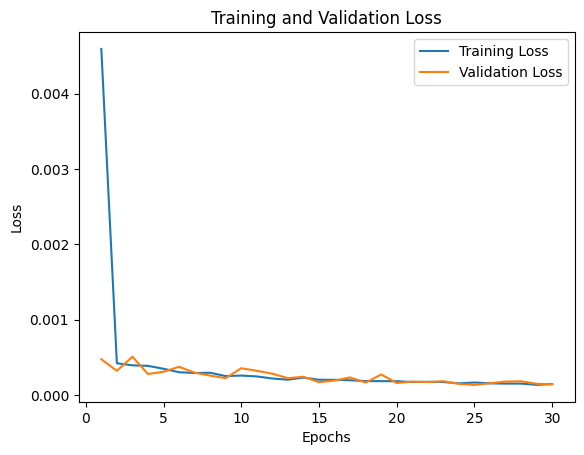

In [ ]:
import matplotlib.pyplot as plt
# Extract loss values from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the loss curves
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Model 3: Using Best Hyperparameters to obtain optimum look-back window

In [ ]:
# Load the dataset into a DataFrame
df = pd.read_csv(csv_file_path)

# Display the first few rows of the DataFrame
df.head(5)

,Date,Day of Week(0-6),Day of the Month(1-31),Month of the Year(1-12),Time of Day(0-23),Holidays,Humidity,Temperature,Load WEST
0,1/1/2012,6,1,1,1,1,34.89,13.2,849.000892
1,1/1/2012,6,1,1,2,1,37.89,12.0,845.097364
2,1/1/2012,6,1,1,3,1,46.46,10.2,840.902849
3,1/1/2012,6,1,1,4,1,54.48,8.4,845.452257
4,1/1/2012,6,1,1,5,1,63.22,6.6,862.369386


In [ ]:
# Extract features and target variable
features = ['Day of Week(0-6)', 'Day of the Month(1-31)', 'Month of the Year(1-12)', 'Time of Day(0-23)', 'Holidays', 'Humidity', 'Temperature']
target_variable = 'Load WEST'
data = df[['Day of Week(0-6)', 'Day of the Month(1-31)', 'Month of the Year(1-12)', 'Time of Day(0-23)', 'Holidays', 'Humidity', 'Temperature', 'Load WEST']]

In [ ]:
# Normalize data using Min-Max normalization
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data)

In [ ]:
type(data_normalized)

numpy.ndarray

In [ ]:
data_normalized.shape

(35064, 8)

In [ ]:
#2015 starts from row 26304
#checking
data.iloc[26303]

Day of Week(0-6)              3.00000
Day of the Month(1-31)        1.00000
Month of the Year(1-12)       1.00000
Time of Day(0-23)             0.00000
Holidays                      1.00000
Humidity                     77.15000
Temperature                   1.20000
Load WEST                  1504.43762
Name: 26303, dtype: float64

In [ ]:
data_normalized[26303]

array([0.5       , 0.        , 0.        , 0.        , 1.        ,
       0.75412989, 0.20517928, 0.69694446])

In [ ]:
train_set=data_normalized[:26303]
test_set=data_normalized[26303:]

In [ ]:
print(train_set.shape)
print(test_set.shape)

(26303, 8)
(8761, 8)


In [ ]:
# Function to prepare sequences for LSTM
def prepare_sequences(data, look_back):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), :])
        y.append(data[i + look_back, -1])  # Assuming Load WEST is the last column
    return np.array(X), np.array(y)

# Set the look-back window
# look_back = 12 # Adjust this value based on your analysis

In [ ]:
pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 2.5 MB/s eta 0:00:00


In [ ]:
# Best GRU Model Architecture

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Function to build the model with specific hyperparameters
def build_model_with_params(units, num_layers, units_last, input_shape):
    model = Sequential()

    # Add the first GRU layer
    model.add(GRU(units=units, return_sequences=True, input_shape=input_shape))

    # Add intermediate GRU layers
    for _ in range(num_layers):
        model.add(GRU(units=units, return_sequences=True))

    # Add the last GRU layer with return_sequences=False
    model.add(GRU(units=units_last, return_sequences=False))

    # Add a Dense layer for final prediction
    model.add(Dense(units=1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    return model

# Best Hyperparameters obtained from tuning
best_units = 50
best_num_layers = 4
best_units_last = 30

# Input shape based on your data
input_shape = (12, 8)  # Update features_count based on your data

# Build the model with best hyperparameters
best_model = build_model_with_params(units=best_units, num_layers=best_num_layers, units_last=best_units_last, input_shape=input_shape)

# Print model summary
best_model.summary()



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_13 (GRU)                (None, 12, 50)            9000      
                                                                 
 gru_14 (GRU)                (None, 12, 50)            15300     
                                                                 
 gru_15 (GRU)                (None, 12, 50)            15300     
                                                                 
 gru_16 (GRU)                (None, 12, 50)            15300     
                                                                 
 gru_17 (GRU)                (None, 12, 50)            15300     
                                                                 
 gru_18 (GRU)                (None, 30)                7380      
                                                                 
 dense_2 (Dense)             (None, 1)                

In [ ]:
# Import necessary libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping


# Function to build the model with specific hyperparameters
def build_model_with_params(units, num_layers, units_last, input_shape):
    model = Sequential()

    # Add the first GRU layer
    model.add(GRU(units=units, return_sequences=True, input_shape=input_shape))

    # Add intermediate GRU layers
    for _ in range(num_layers):
        model.add(GRU(units=units, return_sequences=True))

    # Add the last GRU layer with return_sequences=False
    model.add(GRU(units=units_last, return_sequences=False))

    # Add a Dense layer for final prediction
    model.add(Dense(units=1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    return model

# Best Hyperparameters obtained from tuning
best_units = 50
best_num_layers = 4
best_units_last = 30

# Input shape based on your data
# input_shape = (X_train.shape[1], X_train.shape[2])

# Automate for different look-back windows
look_back_values = [2, 4 ,6, 8 ,10 ,12 ,14 ,16 ,18 ,20 , 22, 24]

for look_back in look_back_values:
    #X, y = prepare_sequences(data_normalized, look_back)

    # Split the data into training, validation, and testing sets
    #X_train_current, X_temp, y_train_current, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    #X_val_current, X_test, y_val_current, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    # Prepare sequences for train set
    X_train_I, y_train_I = prepare_sequences(train_set, look_back)
    # Prepare sequences for test set
    X_test, y_test = prepare_sequences(test_set, look_back)

    # Split the data into training, validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train_I, y_train_I, test_size=0.2, random_state=42)

    # Build the model with specific hyperparameters
    current_model = build_model_with_params(units=best_units, num_layers=best_num_layers, units_last=best_units_last, input_shape=(X_train.shape[1], X_train.shape[2]))

    # Prepare sequences with the current look_back
   # X_train_current, y_train_current = prepare_sequences(X_train, look_back)
   # X_val_current, y_val_current = prepare_sequences(X_val, look_back)

    # Train the model with EarlyStopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    current_model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping])

    # Make predictions on the validation set
    y_test_pred = current_model.predict(X_test)

    # Invert the predictions and actual values to compare with the original scale
    predictions_original = scaler.inverse_transform(np.concatenate((X_test[:, -1, :-1], y_test_pred.reshape(-1, 1)), axis=1))[:, -1]
    y_test_original = scaler.inverse_transform(np.concatenate((X_test[:, -1, :-1], y_test.reshape(-1, 1)), axis=1))[:, -1]

    # Calculate and print metrics
    mse = mean_squared_error(y_test_original, predictions_original)
    mae = mean_absolute_error(y_test_original, predictions_original)
    mape = mean_absolute_percentage_error(y_test_original, predictions_original)*100
    rmse = np.sqrt(mse)
    #r2 = r2_score(y_test_original, predictions_original)

    print(f"Look Back: {look_back}")
    print(f"MSE: {mse}")
    print(f"MAE: {mae}")
    print(f"MAPE: {mape}")
    print(f"RMSE: {rmse}")
    #print(f"R2: {r2}")
    print("--------------------")




Epoch 1/100
658/658 [==============================] - 29s 24ms/step - loss: 0.0071 - val_loss: 9.1988e-04
Epoch 2/100
658/658 [==============================] - 13s 19ms/step - loss: 5.3365e-04 - val_loss: 3.4852e-04
Epoch 3/100
658/658 [==============================] - 12s 18ms/step - loss: 4.0043e-04 - val_loss: 3.8756e-04
Epoch 4/100
658/658 [==============================] - 12s 18ms/step - loss: 3.8898e-04 - val_loss: 3.2845e-04
Epoch 5/100
658/658 [==============================] - 13s 19ms/step - loss: 3.8225e-04 - val_loss: 6.7509e-04
Epoch 6/100
658/658 [==============================] - 12s 19ms/step - loss: 3.8261e-04 - val_loss: 3.8662e-04
Epoch 7/100
658/658 [==============================] - 11s 17ms/step - loss: 3.6226e-04 - val_loss: 4.5833e-04
Epoch 8/100
658/658 [==============================] - 13s 19ms/step - loss: 3.6134e-04 - val_loss: 4.3160e-04
Epoch 9/100
274/274 [==============================] - 3s 4ms/step
Look Back: 2
MSE: 533.0656143113249
MAE: 16.76671